In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 样本

## 样本生成
用于生成（0,1]间的随机数  
缺点：不能很好的控制各亚组的样本数量

# H0m=m0 v.s. H1:m>m0 下的参数估计

In [2]:
def normal(x,theta):
    mu=theta[0]
    s=theta[1]#标准差
    result=(1/(np.sqrt(2*np.pi)*s))*np.exp(-1*(x-mu)**2/(2*s**2))
    return result

def mixnormal(x,theta):
    m=theta.shape[1]
    result=0
    for i in range(m):
        result+=theta[0,i]*normal(x,theta[1:,i])
    return result

def Lih(X,theta):
    num=X.shape[0]
    C=theta.shape[1]
    Ga=np.zeros((num,C))
    c=np.zeros(C)

    for j in range(num):#响应度
        for k in range(C):
            c[k]=theta[0,k]*normal(X[j],theta[1:,k])
        Ga[j]=c/np.sum(c)

    return Ga

In [3]:
data0=np.loadtxt("C:/Users/Administrator/Desktop/a.csv",delimiter=",")

In [4]:
Ca=1
tp=0.068
N=data0.shape[0]

In [5]:
def ps(x,y,an=0.25):#对方差的惩罚函数
    z=-an*(np.log(x**2/y**2)+(y**2/x**2)-1)
    return z

def pa(α):#对系数的惩罚函数
    z=Ca*np.log(1-abs(1-2*α))
    return z

## H0下的最大惩罚似然计算

In [6]:
'''
原假设下的惩罚对数似然,这里只对方差惩罚，不对α惩罚
因为H0为m=1时有惩罚似然最大中在α=0.5取到，自然设置α=0.5
H0为m=m0>=2时，有充分的理由认为不会发生不可识别问题，即αh(h=1,2,...,m0)不会落在界点上
'''
def pl0(data,theta,tp):
    n=data.shape[0]
    m=theta.shape[1]
    y=np.zeros(n)
    ssvar=np.var(data)
    a=0
    for h in range(m):
        a+=ps(theta[2,h],ssvar,tp)
    for i in range(n):
        y[i]=np.log(mixnormal(data[i],theta))
    z=np.sum(y)+a
    return z

In [7]:
def ECMforH0(data,thetaold,theta0):
    num=data.shape[0]
    L0=Lih(data,thetaold)
    C=thetaold.shape[1]
    d=np.zeros(C)
    thetanext=np.zeros((3,C))

    datanew=data
    for k in range(C):#更新参数
        d[k]=np.sum(L0[:,k])
        thetanext[0,k]=d[k]/num
        thetanext[1,k]=np.dot(L0[:,k],datanew[:])/d[k]
        thetanext[2,k]=np.sqrt((np.dot(L0[:,k],(datanew[:]-thetanext[1,k])**2)+2*tp*theta0[2,k])/(d[k]+2*tp))#标准差

    return thetanext


In [8]:
def iterECMforH0(data,theta0,N=1000):
    T0=theta0
    for i in range(N):
        T0=ECMforH0(data,T0,theta0)

    return T0,i

### 获取H0下的最优估计

#### beta的初值

#### 其他参数的初值选取

#### H0:m=1

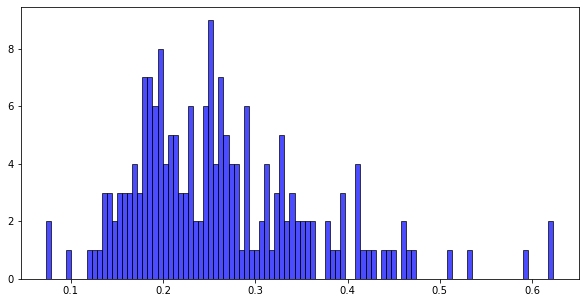

In [9]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot()
ax1.hist(data0, bins=100,  facecolor="blue", edgecolor="black", alpha=0.7)
plt.show()

In [10]:
smean=np.mean(data0)
sstd=np.std(data0)
ssvar=np.var(data0)
stheta0=np.array([[0.5],[smean],[sstd]])
stheta0#样本均值与样本的标准差

array([[0.5       ],
       [0.26322632],
       [0.09831687]])

In [11]:
sr00=pl0(data0,stheta0,tp=0.25)
sr00

38.507853786571495

#### H0:m>=2（待改进）

In [12]:
m0=2#H0的假设
weight0=[0.6,0.4]
mean0=[0.2,0.3]
#分位数定均值初值
covs0=[0.05,0.05]
theta0=np.array([weight0,mean0,covs0])

In [13]:
print(' 初值:\n','参数初值:\n',theta0)

 初值:
 参数初值:
 [[0.6  0.4 ]
 [0.2  0.3 ]
 [0.05 0.05]]


In [14]:
result=iterECMforH0(data0,theta0,50)
result

(array([[0.66700302, 0.33299698],
        [0.22104328, 0.3477202 ],
        [0.05733803, 0.10918555]]),
 49)

In [15]:
result[0][2]**2

array([0.00328765, 0.01192149])

In [16]:
thetaH0=result[0]

In [17]:
#H0下的惩罚似然
sr01=pl0(data0,thetaH0,tp)
sr01

187.60295004539233

## H1下的似然计算

#混合正态的惩罚联合对数似然,注意这里的x为Yi-Xi.T*beta,k表示第k个初始值
def pl1(k,data,theta,th0,C=1):
    n=data.shape[0]
    m=th0.shape[1]
    y=np.zeros(n)
    a=0
    for h in range(m):
        a+=ps(theta[2,(2*h)],th0[2,h],tp)+ps(theta[2,(2*h+1)],th0[2,h],tp)+pa(theta[0,2*h],C)+pa(theta[k,(2*h+1)],C)
    for i in range(n):
        y[i]=np.log(mixnormal(data[i],theta))
    z=np.sum(y)+a
    return z

In [18]:
#混合正态的惩罚联合对数似然,注意这里的x为Yi-Xi.T*beta
def pl1(k,data,theta,th0):
    n=data.shape[0]
    m=th0.shape[1]
    y=np.zeros(n)
    a=0
    for h in range(m):
        a+=ps(theta[2,(2*h)],th0[2,h],tp)+ps(theta[2,(2*h+1)],th0[2,h],tp)+pa(aa[k,h])
    for i in range(n):
        y[i]=np.log(mixnormal(data[i],theta))
    z=np.sum(y)+a
    return z

In [19]:
#用来对固定权重迭代参数的ECM.i表示固定为aa中第i个β0
def ECMff(we,data,thetaold,theta0):
    num=data.shape[0]
    L0=Lih(data,thetaold)
    C=int(thetaold.shape[1])
    C0=int(C/2)
    d=np.zeros(C)
    thetanext=np.zeros((3,C))
    thetanext0=np.zeros((3,C0))

    for l in range(C0):
        d[2*l]=np.sum(L0[:,2*l])
        d[2*l+1]=np.sum(L0[:,2*l+1])
        thetanext0[0,l]=(d[2*l]+d[2*l+1])/num
        thetanext[0,2*l]=thetanext0[0,l]*we[l]
        thetanext[0,2*l+1]=thetanext0[0,l]*(1-we[l])

    for k in range(C):#更新参数
        thetanext[1,k]=np.dot(L0[:,k],data[:])/d[k]
        thetanext[2,k]=np.sqrt((np.dot(L0[:,k],(data[:]-thetanext[1,k])**2)+2*tp*theta0[2,k])/(d[k]+2*tp))#标准差

    return thetanext


In [20]:
def iterECMff(data,theta0,N=1000):
    C0=int(theta0.shape[1]/2)
    we=np.zeros(C0)
    for l in range(C0):
        we[l]=(theta0[0,2*l])/(theta0[0,2*l]+theta0[0,2*l+1])
    T0=theta0
    for i in range(N):
        T0=ECMff(we,data,T0,theta0)
    return T0,i

In [21]:
#对于H1下的一次迭代的参数估计
def ECMforH1(data,thetaold,theta0):
    num=data.shape[0]
    L0=Lih(data,thetaold)
    C=int(thetaold.shape[1])
    C0=int(C/2)
    d=np.zeros(C)
    thetanext=np.zeros((3,C))
    thetanext0=np.zeros((3,C0))

    for l in range(C0):
        d[2*l]=np.sum(L0[:,2*l])
        d[2*l+1]=np.sum(L0[:,2*l+1])
        thetanext0[0,l]=(d[2*l]+d[2*l+1])/num
        if (d[2*l]/(d[2*l]+d[2*l+1])) <= 0.5:
            if (d[2*l]+Ca)/((d[2*l]+d[2*l+1])+Ca) <= 0.5:
                thetanext[0,2*l]=((d[2*l]+Ca)/((d[2*l]+d[2*l+1])+Ca))*thetanext0[0,l]
                thetanext[0,2*l+1]=((d[2*l+1])/((d[2*l]+d[2*l+1])+Ca))*thetanext0[0,l]
            else:
                thetanext[0,2*l]=0.5*thetanext0[0,l]
                thetanext[0,2*l+1]=0.5*thetanext0[0,l]
        else:
            if (d[2*l])/((d[2*l]+d[2*l+1])+Ca) > 0.5:
                thetanext[0,2*l]=((d[2*l])/((d[2*l]+d[2*l+1])+Ca))*thetanext0[0,l]
                thetanext[0,2*l+1]=((d[2*l+1]+Ca)/((d[2*l]+d[2*l+1])+Ca))*thetanext0[0,l]
            else:
                thetanext[0,2*l]=0.5*thetanext0[0,l]
                thetanext[0,2*l+1]=0.5*thetanext0[0,l]

    for k in range(C):#更新参数
        thetanext[1,k]=np.dot(L0[:,k],data[:])/d[k]
        thetanext[2,k]=np.sqrt((np.dot(L0[:,k],(data[:]-thetanext[1,k])**2)+2*tp*theta0[2,k])/(d[k]+2*tp))#标准差

    return thetanext


In [22]:
def iterECMforH1(data,theta0,N=1000):
    T0=theta0
    for i in range(N):
        T0=ECMforH1(data,T0,theta0)

    return T0,i

### step 0 设定不同的初值
m0个数组的排列问题  
当m0为确定的数时，只需要套m0个循环即可  
如果m0未知，无法用上述想法做了，可以将循环问题转为递归问题  
或者用查询的方法做

In [23]:
m0=2

In [24]:
Weight=np.array([0.1,0.9,0.3,0.7,0.5])
Weight0=np.zeros((5**m0,2*m0))#H1下的初始权重
aa=np.zeros((5**m0,m0))

In [25]:
for i in range (5**m0):
    for j in range(m0):
        a=np.floor(i/(5**(m0-j-1)))
        if a>4:
            a=a-5*np.floor(a/5)
        b=int(a)
        aa[i,j]=Weight[b]
        Weight0[i,2*j]=Weight[b]*thetaH0[0,j]
        Weight0[i,2*j+1]=(1-Weight[b])*thetaH0[0,j]

### step 1 固定参数的不同初值下，分别选取使得惩罚似然达到最大的正态参数
（ECMff多次迭代即可）

In [26]:
thetaH0

array([[0.66700302, 0.33299698],
       [0.22104328, 0.3477202 ],
       [0.05733803, 0.10918555]])

In [27]:
result[0]

array([[0.66700302, 0.33299698],
       [0.22104328, 0.3477202 ],
       [0.05733803, 0.10918555]])

In [28]:
Weight0[-5:]

array([[0.33350151, 0.33350151, 0.0332997 , 0.29969728],
       [0.33350151, 0.33350151, 0.29969728, 0.0332997 ],
       [0.33350151, 0.33350151, 0.09989909, 0.23309789],
       [0.33350151, 0.33350151, 0.23309789, 0.09989909],
       [0.33350151, 0.33350151, 0.16649849, 0.16649849]])

In [29]:
Th=np.zeros((5**m0,3,2*m0))
for i in range(5**m0):
    thetan=np.array((Weight0[i],[0.15,0.25,0.3,0.4],[0.025,0.025,0.05,0.05]))
    res=iterECMff(data0,thetan,100)
    Th[i]=res[0]

'''
Th[i]表示第i个权重初值下的最佳参数初值  
Be[i]表示第i个权重初值下的最佳斜率初值  
以上均作为最早的初值参与迭代
'''

'\nTh[i]表示第i个权重初值下的最佳参数初值  \nBe[i]表示第i个权重初值下的最佳斜率初值  \n以上均作为最早的初值参与迭代\n'

### step 2 分别选定初始参数后的迭代（只需迭代几次）

In [53]:
rs=np.zeros(5**m0)
Th1=np.zeros((5**m0,3,2*m0))
for i in range(5**m0):
    res=iterECMforH1(data0,Th[i],3)
    Th1[i]=res[0]
    rs[i]=pl1(i,data0,Th1[i],stheta0)

In [54]:
rs

array([187.53742429, 187.59378006, 187.00127855, 187.46790404,
       187.29480941, 186.79882964, 187.55919997, 187.05271739,
       187.42856522, 187.24301591, 188.46318874, 188.77030716,
       188.53018069, 188.70291335, 188.64644444, 188.43289498,
       188.70605317, 188.47652232, 188.60185929, 188.52808341,
       188.93696396, 189.26093595, 188.98814652, 189.15550922,
       189.06685284])

In [41]:
2*(rs-sr01)

array([-0.13105152, -0.01833996, -1.203343  , -0.27009201, -0.61628128,
       -1.6082408 , -0.08750016, -1.1004653 , -0.34876965, -0.71986826,
        1.7204774 ,  2.33471423,  1.85446129,  2.19992661,  2.08698879,
        1.65988986,  2.20620624,  1.74714455,  1.99781849,  1.85026673,
        2.66802782,  3.31597181,  2.77039296,  3.10511834,  2.92780558])

In [42]:
np.max(2*(rs-sr01))

3.315971813492581

In [67]:
np.where(2*(rs-sr01)==np.max(2*(rs-sr01)))[0]

array([21], dtype=int64)

In [49]:
Th1[zx]

array([[[0.31693809, 0.31693809, 0.3200681 , 0.04605573],
        [0.19859308, 0.23840737, 0.32041462, 0.49968507],
        [0.0462951 , 0.06327775, 0.08827964, 0.10767282]]])

In [50]:
Th1[zx][0]

array([[0.31693809, 0.31693809, 0.3200681 , 0.04605573],
       [0.19859308, 0.23840737, 0.32041462, 0.49968507],
       [0.0462951 , 0.06327775, 0.08827964, 0.10767282]])

### step 3
每次找出使得H1下惩罚似然达到最大的那个初始参数，计算对应的似然比统计量

# EM值计算

## ECM的迭代算法
```
def iterECM(Xs,Y,beta0,theta0,tp=0.002,N=1000,ε=0.005):
    T0=[beta0,theta0]
    for i in range(N):
        a=T0[0]
        T0=ECM(Xs,Y,T0[0],T0[1],theta0,tp)
        b=np.linalg.norm(T0[0]-a)
        '''
        if b<=ε:
            break
        '''
    return T0,b,i
```

In [36]:
np.savetxt('b.csv',data0,delimiter=",")

In [37]:
Data=np.loadtxt("C:/Users/Administrator/Desktop/a.csv",delimiter=",")

In [38]:
alpha=[0.1,0.2,0.3]
for i in range(3):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-38-89c1a6e122c2>, line 3)